In [61]:
import sys
sys.path.append('/home/shinzato/GitHub/power-law-research/power_law_research')
from collections import OrderedDict
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from data_modules import FashionMNISTDataModule


class ScaleFreeLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:

class LitScaleFreeAutoEncoder(pl.LightningModule):
    def __init__(self, n_vis, n_hid=100, optimizer_name="sgd", lr=0.01, power_law_gamma=1):
        super().__init__()
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.optimizer_name = optimizer_name
        self.lr = lr
        self.encoder = nn.Sequential(
            OrderedDict(
                [
                    ("enc_fc1", nn.Linear(n_vis, n_hid)),
                    ("enc_relu1", nn.ReLU()),
                ]
            )
        )
        w_decay = torch.tensor([n**(-power_law_gamma) for n in range(1, n_hid + 1)]).expand(n_vis, n_hid).t()
        self.encoder.enc_fc1.weight = self.encoder.enc_fc1.weight * w_decay
        self.decoder = nn.Sequential(nn.Linear(n_hid, n_vis), nn.Sigmoid())
        
    def encode(self, v):
        return self.encoder(v)
    
    def decode(self, h):
        return self.decoder(h)
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def configure_optimizers(self):
        if self.optimizer_name == "sgd":
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        elif self.optimizer_name == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        else:
            raise NotImplementedError
        return optimizer
    
    def train_loss(self, tensor):
        batch = tensor.size(0)
        x = tensor.view(batch, -1)
        recon = self.forward(x)
        return F.mse_loss(x, recon)
    
    def training_step(self, batch, batch_idx):
        tensor, label = batch
        loss = self.train_loss(tensor)
        self.log("train_loss", loss)
        return loss
    

In [62]:
data_module = FashionMNISTDataModule(batch_size=128)
data_module.setup()
for data, label in data_module.train_dataloader():
    print("data", data.shape)
    print("batch", data.size(0))
    print("x", data.view(data.size(0), -1).shape)
    break

model = LitScaleFreeAutoEncoder(n_vis=784, n_hid=100)
model.encoder.enc_fc1.weight.shape

data torch.Size([128, 1, 28, 28])
batch 128
x torch.Size([128, 784])


TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [60]:
power_law_gamma = 1
n_vis = 784
n_hid = 100
w_decay = torch.tensor([n**(-power_law_gamma) for n in range(1, n_hid + 1)]).expand(n_vis, n_hid)
print(w_decay.shape)
w_decay.t()

encoder = nn.Linear(n_vis, n_hid)
print("w", encoder.weight.shape)

torch.Size([784, 100])
w torch.Size([100, 784])


In [58]:
from datetime import datetime
from data_modules import FashionMNISTDataModule

logger = pl.loggers.TensorBoardLogger(save_dir=f"../log/{str(datetime.now())}_autoencoder")
model = LitScaleFreeAutoEncoder(n_vis=784, n_hid=1000)
data_module = FashionMNISTDataModule(batch_size=128)
trainer = pl.Trainer(max_epochs=10, devices=1, accelerator="gpu", logger=logger)
trainer.fit(model, data_module)

RuntimeError: The size of tensor a (784) must match the size of tensor b (1000) at non-singleton dimension 1

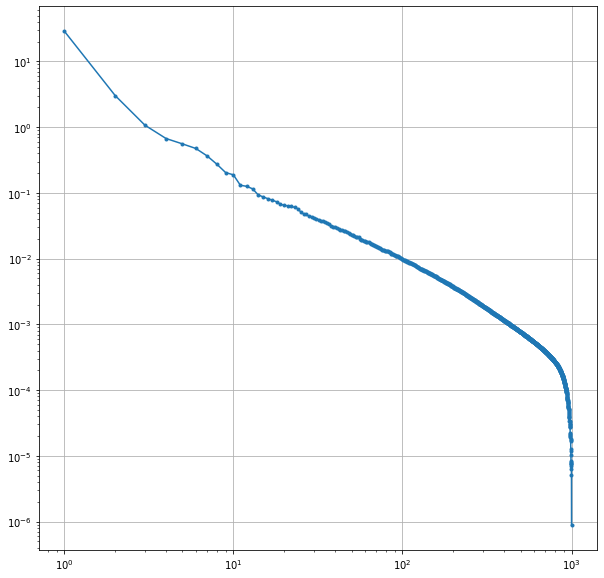

In [19]:
import numpy as np
from utils import sample_neuron_firings, pca_variance
import matplotlib.pyplot as plt

firings = sample_neuron_firings(model, data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)



fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-")